In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, brentq
from IPython.display import display

import rmgpy.constants as constants
import rmgpy.quantity as quantity
from rmgpy.cantherm.statmech import StatMechJob
from rmgpy.species import Species
from rmgpy.pdep.configuration import Configuration
from rmgpy.pdep.network import Network

Using Theano backend.
/Users/mjliu/Code/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mjliu/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mjliu/anaconda2/envs/rmg_e

In [2]:
path = '/Users/mjliu/Code/RMG-Py/examples/cantherm/species/C2H4/ethene.py'

spc = Species(label='ethene')

job = StatMechJob(spc, path)
job.modelChemistry = 'CBS-QB3'.lower()
job.load()

In [3]:
network = Network(
    label = 'test',
    isomers = [Configuration(spc)],
    reactants = [], 
    products = [],
    pathReactions = [],
    bathGas = [],
)

In [4]:
network.Tmin = quantity.Temperature((300.0, 'K')).value_si
network.Tmax = quantity.Temperature((3000.0, 'K')).value_si
network.Pmin = quantity.Pressure((.01, 'bar')).value_si
network.Pmax = quantity.Pressure((100.0, 'bar')).value_si
network.grainSize = quantity.Energy((1.0, 'kcal/mol'))
network.grainCount = 250

network.Nisom = len(network.isomers)
network.Nreac = len(network.reactants)
network.Nprod = len(network.products)
network.Ngrains = 0
network.NJ = 0

# Calculate ground-state energies
network.E0 = np.zeros((network.Nisom+network.Nreac+network.Nprod), np.float64)
for i in range(network.Nisom):
    network.E0[i] = network.isomers[i].E0
for n in range(network.Nreac):
    network.E0[n+network.Nisom] = network.reactants[n].E0
for n in range(network.Nprod):
    network.E0[n+network.Nisom+network.Nreac] = network.products[n].E0

# Calculate densities of states
network.activeJRotor = True
network.activeKRotor = False
network.rmgmode = False

In [5]:
Elist = network.selectEmax()

0.162487904052 1.18348711207 0.730291992459
New factor = 18.1944491914


0.0216108310274


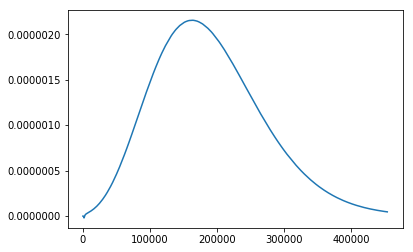

In [6]:
eqDist = network.isomers[0].densStates * np.exp(-Elist/constants.R/network.Tmax)
eqDist *= 1e-6
plt.plot(Elist, eqDist)

frac = eqDist[-1] / eqDist.max()
print frac

In [38]:
def determineEmax(self, factor=None, tolerance=0.01):
    # Guess a factor based on molecule size
    if factor is None:
        factor = 10.
    
    # Calculate density of states
    Elist = calculateDensitiesOfStates(self, factor=factor)
    
    # Get the equilibrium distribution for an isomer
    eqDist = self.isomers[0].densStates * np.exp(-Elist/constants.R/self.Tmax)
    
    # Scale Elist for easier fitting
    Elist *= 1e-6
    
    plt.plot(Elist, eqDist)
    
    # Check if the last point is past the peak of the distribution
    maxY = eqDist.max()
    maxX = Elist[np.argmax(eqDist)]
    print maxX, maxY, eqDist[-1]
    
    if eqDist[-1] < maxY:
        # Check if the last point is within the tolerance relative to the max
        if eqDist[-1] / maxY > tolerance:
            # Fit a curve to the distribution
            popt, pcov = curve_fit(lambda x, a, b: a*x**2*np.exp(b*x**2), Elist, eqDist, p0=[100, -10])
            # Find the energy at which we reach the tolerance
            target = maxY * tolerance
            Emax = brentq(lambda x: target - popt[0]*x**2*np.exp(popt[1]*x**2), maxX, 1)
            # Adjust the factor to reach this energy
            factor += (Emax - Elist[-1]) / constants.R / self.Tmax
            
            print 'New factor = {0}'.format(factor)
            
            Elist2 = np.linspace(0, 0.5, 100)
            eqDist2 = popt[0] * Elist2**2 * np.exp(popt[1] * Elist2**2)
            plt.plot(Elist2, eqDist2)
            
    else:
        # Manually increment the factor for more accurate fitting
        factor += 10
        determineEmax(self, factor=factor)
    
    # Recalculate density of states
    calculateDensitiesOfStates(self, factor=factor)
    
    # Update Emax
    self.Emax = Emax

0.162487904052 1.18348711207 0.730291992459
New factor = 10.0000081944


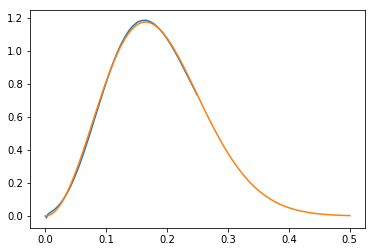

In [39]:
determineEmax(network)

0.617067972274


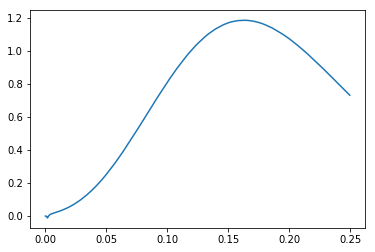

In [27]:
dens_states, e_list = calculateDensitiesOfStates(network, factor=10.)

states = dens_states * np.exp(-e_list/constants.R/network.Tmax)
sum_of_states = np.trapz(states, e_list)
eq_dist = states / sum_of_states

e_list *= 1e-6
plt.plot(e_list, states)

frac = eq_dist[-1] / eq_dist.max()
print frac

# popt, pcov = curve_fit(lambda x, a, b: a*x**2*np.exp(b*x**2), e_list, states, p0=[100, -10])
# print popt
# e_list_2 = np.linspace(0, 0.5, 100)
# eq_2 = popt[0] * e_list_2**2 * np.exp(popt[1] * e_list_2**2)
# # print eq_2
# plt.plot(e_list_2, eq_2)
# # e_list_3 = np.linspace(0, 0.4, 100)
# # eq_3 = 6e-4 * e_list_3**2 * np.exp(-30 * e_list_3**2)
# # plt.plot(e_list_3, eq_3)

# dens_states, e_list = calculateDensitiesOfStates(network, multiplier=30.)
# states = dens_states * np.exp(-e_list/constants.R/network.Tmax)
# sum_of_states = np.trapz(states, e_list)
# eq_dist = states / sum_of_states

# e_list *= 1e-6
# plt.plot(e_list, states/6)

# frac = eq_dist[-1] / eq_dist.max()
# print frac



In [29]:
def calculateDensitiesOfStates(self, factor=40.):
    """
    Calculate the densities of states of each configuration that has states
    data. The densities of states are computed such that they can be
    applied to each temperature in the range of interest by interpolation.
    """

    Tmin = self.Tmin
    Tmax = self.Tmax
    grainSize = self.grainSize
    grainCount = self.grainCount

    Nisom = self.Nisom
    Nreac = self.Nreac
    Nprod = self.Nprod

    # Choose the energies used to compute the densities of states
    # Use Tmin to select the minimum energy and grain size
    Elist0 = self.selectEnergyGrains(Tmin, grainSize, grainCount, factor)
    Emin0 = np.min(Elist0)
    grainSize0 = Elist0[1] - Elist0[0]
    # Use Tmax to select the maximum energy and grain count
    Elist0 = self.selectEnergyGrains(Tmax, grainSize, grainCount, factor)
    grainCount0 = len(Elist0)
    Emax0 = np.max(Elist0)

    Elist = self._Network__getEnergyGrains(Emin0, Emax0, grainSize0, grainCount0)
    Ngrains = len(Elist)
    dE = Elist[1] - Elist[0]

    # Shift the energy grains so that the minimum grain is zero
    Elist -= Elist[0]

    densStates = np.zeros((Nisom+Nreac+Nprod, Ngrains), np.float64)

    # Densities of states for isomers
    for i in range(Nisom):
        self.isomers[i].calculateDensityOfStates(Elist, activeKRotor=self.activeKRotor, activeJRotor=self.activeJRotor, rmgmode=self.rmgmode)

    # Densities of states for reactant channels
    for n in range(Nreac):
        if self.reactants[n].hasStatMech():
            self.reactants[n].calculateDensityOfStates(Elist, activeKRotor=self.activeKRotor, activeJRotor=self.activeJRotor, rmgmode=self.rmgmode)
    # Densities of states for product channels
    if not self.rmgmode:
        for n in range(Nprod):
            if self.products[n].hasStatMech():
                self.products[n].calculateDensityOfStates(Elist, activeKRotor=self.activeKRotor, activeJRotor=self.activeJRotor, rmgmode=self.rmgmode)

#     def eq_dist(species):
#         densstates = species.densStates / (Elist[1] - Elist[0])
#         states = densstates * np.exp(-Elist/constants.R/Tmax)
#         sum_of_states = np.trapz(states, Elist)
#         return 1e6 * states / sum_of_states

#     for i in range(Nisom):
#         plt.plot(Elist*0.001, eq_dist(self.isomers[i]))
#     for n in range(Nreac):
#         if self.reactants[n].densStates is not None:
#             plt.plot(Elist*0.001, eq_dist(self.reactants[n]))
#     for n in range(Nprod):
#         if self.products[n].densStates is not None:
#             plt.plot(Elist*0.001, eq_dist(self.products[n]))

    #return self.isomers[0].densStates, Elist
    return Elist